In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt


import pmdarima as pm
import statsmodels as st

from utils_time_series import *
from utils_xgb_classifier import *

In [2]:
ticker = "AAPL"
using_papermill = False
q_tails = 0.15

corr_threshold = 0.05
corr_threshold_sentiment = corr_threshold
corr_threshold_returns = corr_threshold
MAX_FEATURES_PER_CATEGORY = 5

threshold = '2020-03-01 23:59:00'

In [3]:
# Parameters
ticker = "GS"
using_papermill = True


In [4]:
if not using_papermill:
    %load_ext autoreload
    %autoreload 2
    stocks = {}
    for file in os.listdir("stocks"):
        if ".parquet" in file:
            stock_name = file.rstrip(".parquet")
            df = pd.read_parquet(f"stocks/{file}")
            stocks[stock_name] = df
    print(stocks.keys())
    
    df = stocks[ticker]
else:
    df = pd.read_parquet(f"stocks/{ticker}.parquet")
    

In [5]:
df_raw = df.copy()

df["Close_diff"] = df.Close.diff(1)
df = (df.set_index("date")
        .asfreq("D")
        .ffill()
        .bfill()
     )
#we fill saturdays and sundays with friday values

df["returns"] = df.Close.pct_change().fillna(0)
df["tomorrow_market_closed"] = df.index.weekday.isin([4,5])

In [6]:
train_df, test_df = train_test_split(df, threshold, )

## Feature engineering

### Sentiment score lags
We compute the correlation between returns and lags of the newspaper sentiment variable and select the most correlated ones, given a threshold

In [7]:

def best_sentiment_score_lags(df, ticker, num_lags = 30, corr_threshold = 0.1):
    df = df.copy()
    for i in range(0,num_lags):
        df[f"tails_score_lag_{i}"] = df.tails_median_score.shift(i)
    tails_lag_corr = df.corr()[["returns"]].iloc[3:]
    
    fig, ax = plt.subplots(figsize = (10,5))

    tails_lag_corr.plot(ax = ax, title = f"Cross correlation with lagged tails sentiment score: {ticker}")
    plt.xticks(rotation=45)
    plt.show()
    return tails_lag_corr[(tails_lag_corr.abs() > corr_threshold).values].sort_values(by = "returns", ascending = False)
    

### Autocorrelation of returns
We compute the autocorrelation of the returns and get the most correlated lags.

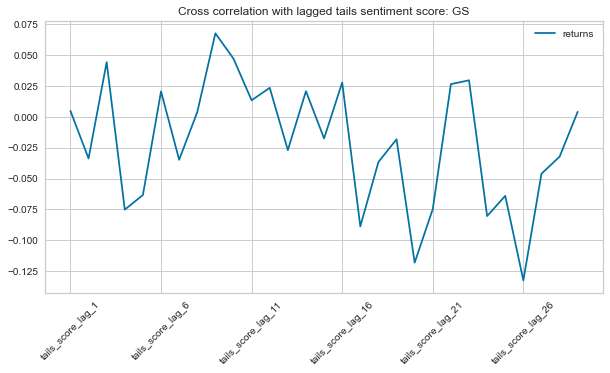

,returns
tails_score_lag_9,0.067803
tails_score_lag_5,-0.063361
tails_score_lag_25,-0.064064
tails_score_lag_21,-0.074748
tails_score_lag_4,-0.075201


In [8]:

tails_df = train_df[["returns", "tails_median_score"]].copy()

# We compute the correlation of the change in the close value with the sentiment score at different lags.
# This way we detect how news correlate with change and how many days does it take to make this change
tails_lag_corr = best_sentiment_score_lags(tails_df, ticker, corr_threshold= corr_threshold_sentiment)
tails_lag_corr.head()

In [9]:
def best_score_lags(df, variable, ticker, num_lags = 30, corr_threshold = 0.1):
    score_lags = df[[variable]].copy()
    for i in range(1,num_lags):
        score_lags[f"{variable}_lag_{i}"] = df[variable].shift(i)
    
    score_lag_corr = score_lags.corr()[[variable]].iloc[1:]
    
    fig, ax = plt.subplots(figsize = (10,5))
    score_lag_corr.plot(ax = ax, title = f"Cross correlation with lagged {variable} score: {ticker}")
    plt.xticks(rotation=45)
    plt.show()
    filtered_score_lags_corr = score_lag_corr[(score_lag_corr.abs() > corr_threshold).values]
    return filtered_score_lags_corr.sort_values(by = variable, ascending = False)

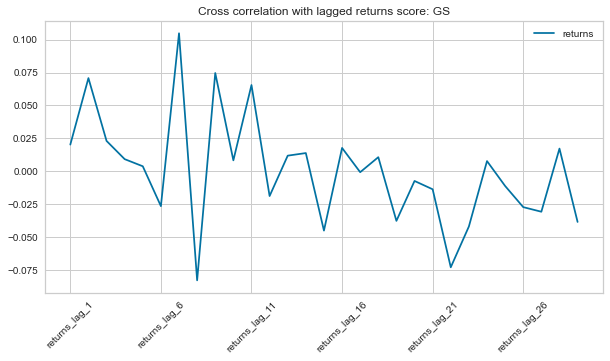

,returns
returns_lag_7,0.104817
returns_lag_9,0.074655
returns_lag_2,0.070785
returns_lag_11,0.065536
returns_lag_22,-0.072802


In [10]:
score_lags_corr = best_score_lags(train_df, "returns", ticker, corr_threshold= corr_threshold_returns)
score_lags_corr.head()

In [11]:

score_lags_corr = score_lags_corr.head(MAX_FEATURES_PER_CATEGORY)
tails_lag_corr = tails_lag_corr.head(MAX_FEATURES_PER_CATEGORY)


for feature in score_lags_corr.index:
    lag_value = int(feature.split("_")[-1])
    df[feature] = df.returns.shift(lag_value)
    
for feature in tails_lag_corr.index:
    lag_value = int(feature.split("_")[-1])
    df[feature] = df.tails_median_score.shift(lag_value)

## Defininig target variable

We bucketize the returns in three categories (BUY, HOLD, SELL).

BUY and SELL are the tails of the distribution.

In [12]:
def bucketize(x, q1, q3):
    if x >= q3:
        return 2
    elif x <= q1:
        return 0
    else:
        return 1

In [13]:

print("Quantiles", q_tails, 1 - q_tails)
non_zero_returns = train_df[train_df.returns != 0].returns
q1,q3 = non_zero_returns.quantile([q_tails, 1 - q_tails])
print("Values", q1,q3)

Quantiles 0.15 0.85
Values -0.011239200736481048 0.013916267383959069


In [14]:
df["target"] = df.returns.apply(bucketize, q1 = q1, q3 = q3).shift(-1) # Super important shifting here

(0.0, 60.0)

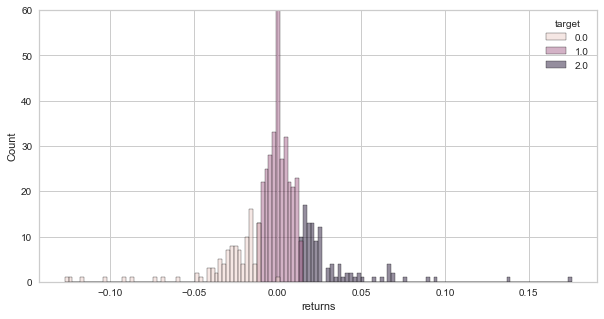

In [15]:
return_dist_df = df[["returns", "target"]].copy()
return_dist_df.target = return_dist_df.target.shift(1)
return_dist_df = return_dist_df.fillna(0)

fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(return_dist_df, x = "returns", hue = "target")
plt.ylim(0, 60)

## Model training

We build an xgboost model only with financial data, another only with newspaper sentiment data, and a third with both types of variables.

For each of this models we also fit a random search to optimize hyperparameters

In [16]:
y_col = "target"
X_cols_stock = ["returns", "tomorrow_market_closed"] + score_lags_corr.index.tolist()
X_cols_news  =  tails_lag_corr.index.tolist()
X_cols_mix   = X_cols_stock + X_cols_news


cols = [y_col] + X_cols_news


train_df, test_df = train_test_split(df, threshold, )#train_pctg = 0.85)


train_df = train_df.dropna(subset = cols)
test_df  =  test_df.dropna(subset = cols)

y_train, y_test = train_df[y_col], test_df[y_col]

X_train_news,  X_test_news  = train_df[X_cols_news], test_df[X_cols_news]
X_train_stock, X_test_stock = train_df[X_cols_stock], test_df[X_cols_stock]
X_train_mix,   X_test_mix   = train_df[X_cols_mix], test_df[X_cols_mix]


In [17]:
models = []

stock_clf = simple_xgb_clf(X_train_stock, y_train, X_test_stock, y_test)
news_clf  = simple_xgb_clf(X_train_news , y_train, X_test_news , y_test)
mix_clf   = simple_xgb_clf(X_train_mix  , y_train, X_test_mix  , y_test)


models.extend([
    TrainedClassifier("stock_clf", X_train_stock, y_train, X_test_stock, y_test, stock_clf),
    TrainedClassifier("news_clf", X_train_news, y_train, X_test_news , y_test, news_clf),
    TrainedClassifier("mix_clf", X_train_mix  , y_train, X_test_mix  , y_test, mix_clf)   
])


In [18]:
stock_rs_clf = random_search_xgb_clf(X_train_stock, y_train, X_test_stock, y_test)
news_rs_clf  = random_search_xgb_clf(X_train_news , y_train, X_test_news , y_test)
mix_rs_clf   = random_search_xgb_clf(X_train_mix  , y_train, X_test_mix  , y_test)

models.extend([
    TrainedClassifier("stock_rs_clf", X_train_stock, y_train, X_test_stock, y_test, stock_rs_clf.best_estimator_),
    TrainedClassifier("news_rs_clf" , X_train_news , y_train, X_test_news , y_test, news_rs_clf.best_estimator_),
    TrainedClassifier("mix_rs_clf"  , X_train_mix  , y_train, X_test_mix  , y_test, mix_rs_clf.best_estimator_)   
])



 Time taken: 0 hours 0 minutes and 6.73 seconds.



 Time taken: 0 hours 0 minutes and 9.65 seconds.



 Time taken: 0 hours 0 minutes and 8.32 seconds.


In [19]:
def random_pred(y, size = None, replace_labels = False):
    "Makes random predictions following the classes imbalanced distribution"
    probs = pd.value_counts(y, normalize = True)
    if size is None:
        size = len(y)
    return np.random.choice(probs.index, size = size, p = probs.values).astype(int)
    if replace_labels:
        return np.array([label_encoding[x] for x in preds])
    else:
        return preds
    

In [20]:
pred_df = test_df[[y_col]].copy()

for model in models:
    pred_df[model.name_pred] = model.y_pred

pred_df["random_pred"] = random_pred(y_train, len(X_test_stock)) #randomly selling and buying following tails probability distribution
#pred_df["hold_pred"] = [2] + (len(pred_df) - 3)*[1] + [0, 0] # Buy first day hold and sell last day


In [21]:
pred_df = pred_df.replace(label_encoding)

## Models metrics

In [22]:
def tails_precision_metric(y_true_array, y_pred_array):
    "For the Buy / sell signals, returns the pctg of correct predictions. "
    count = 0
    correct = 0
    for y_true, y_pred in zip(y_true_array, y_pred_array):
        if y_true in ["sell", "buy"]:
            if y_pred == y_true:
                correct+=1
            count+=1
    return correct / max(1,count)

In [23]:
good_preds = set()
def profitable_investment_metric(y_true_array, y_pred_array):
    "Metric were we are not going against the market (selling when we should have bought/holded or buying/holding when we should have sold"
    correct = 0
    for y_true, y_pred in zip(y_true_array, y_pred_array):
        if y_true in ["buy", "hold"] and y_pred != "sell":
            correct+=1
            good_preds.add((y_true, y_pred))
        elif y_true == "sell" and y_pred == "sell":
            correct+=1
            good_preds.add((y_true, y_pred))
    return correct / len(y_true_array)


In [24]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_dict = {}
f1_score_dict = {}
tails_prec_dict = {}
prof_invest_dict = {}

for pred_var in filter(lambda x : x not in ["Close",  "target"], pred_df.columns):
    accuracy_dict[f"{pred_var}"] = accuracy_score(pred_df.target, pred_df[pred_var], normalize=True)
    f1_score_dict[f"{pred_var}"] = f1_score(pred_df.target, pred_df[pred_var], average="weighted")
    tails_prec_dict[f"{pred_var}"] = tails_precision_metric(pred_df.target, pred_df[pred_var])
    prof_invest_dict[f"{pred_var}"] = profitable_investment_metric(pred_df.target, pred_df[pred_var])

In [25]:
scores_df = pd.DataFrame([accuracy_dict, f1_score_dict, tails_prec_dict, prof_invest_dict], index = ["accuracy", "f1_score", "tails_precision", "prof_invest"]).T
scores_df.style.background_gradient()

,accuracy,f1_score,tails_precision,prof_invest
stock_pred,0.555921,0.494634,0.128000,0.763158
news_pred,0.559211,0.441205,0.016000,0.763158
mix_pred,0.611842,0.531460,0.136000,0.773026
stock_rs_pred,0.555921,0.517668,0.184000,0.733553
news_rs_pred,0.569079,0.498787,0.120000,0.753289
mix_rs_pred,0.572368,0.551750,0.248000,0.720395
random_pred,0.529605,0.474481,0.128000,0.733553


In [26]:
metric = "f1_score"
best_model_name = scores_df[metric].sort_values(ascending = False).index[0]

for model in models:
    if model.name_pred == best_model_name:
        best_model = model
        print("The best model is", best_model_name)
        break

The best model is mix_rs_pred


In [27]:
best_model.feature_importance_df.style.background_gradient()

,features,importance
1,tomorrow_market_closed,0.245999
10,tails_score_lag_21,0.087945
6,returns_lag_22,0.081227
9,tails_score_lag_25,0.075135
5,returns_lag_11,0.073333
0,returns,0.072585
2,returns_lag_7,0.071921
8,tails_score_lag_5,0.061506
11,tails_score_lag_4,0.060640
7,tails_score_lag_9,0.058594


In [28]:
best_model.replace_labels = True
best_model.confusion_matrix_df()

,buy_pred,hold_pred,sell_pred
buy_target,22,26,15
hold_target,19,143,17
sell_target,21,32,9


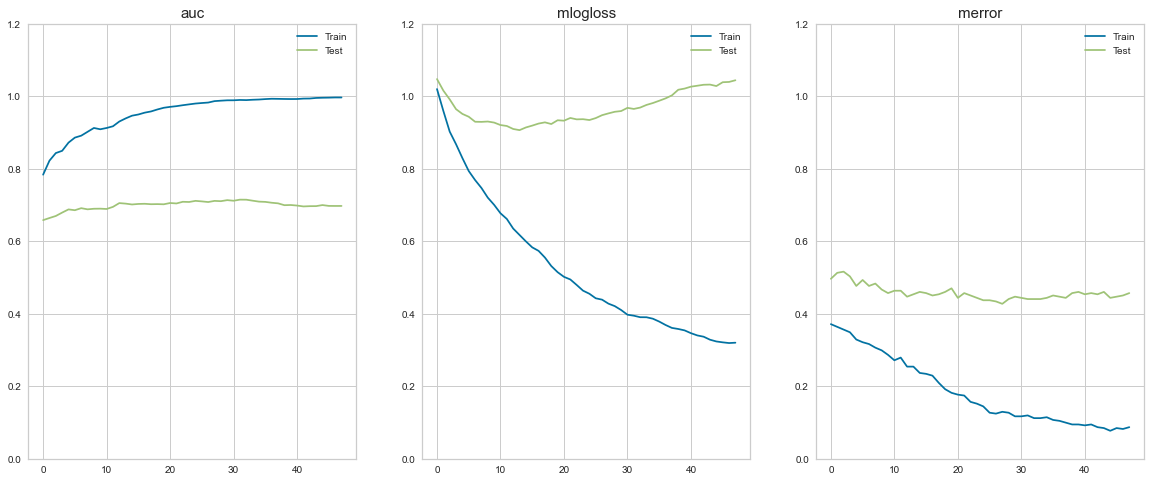

In [29]:
best_model.plot_model_metrics()
pass

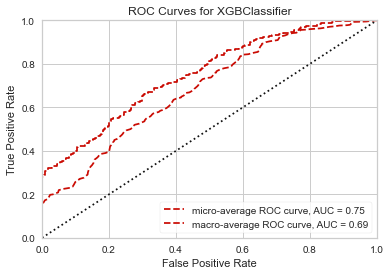

In [30]:
best_model.plot_ROC_curve()
pass

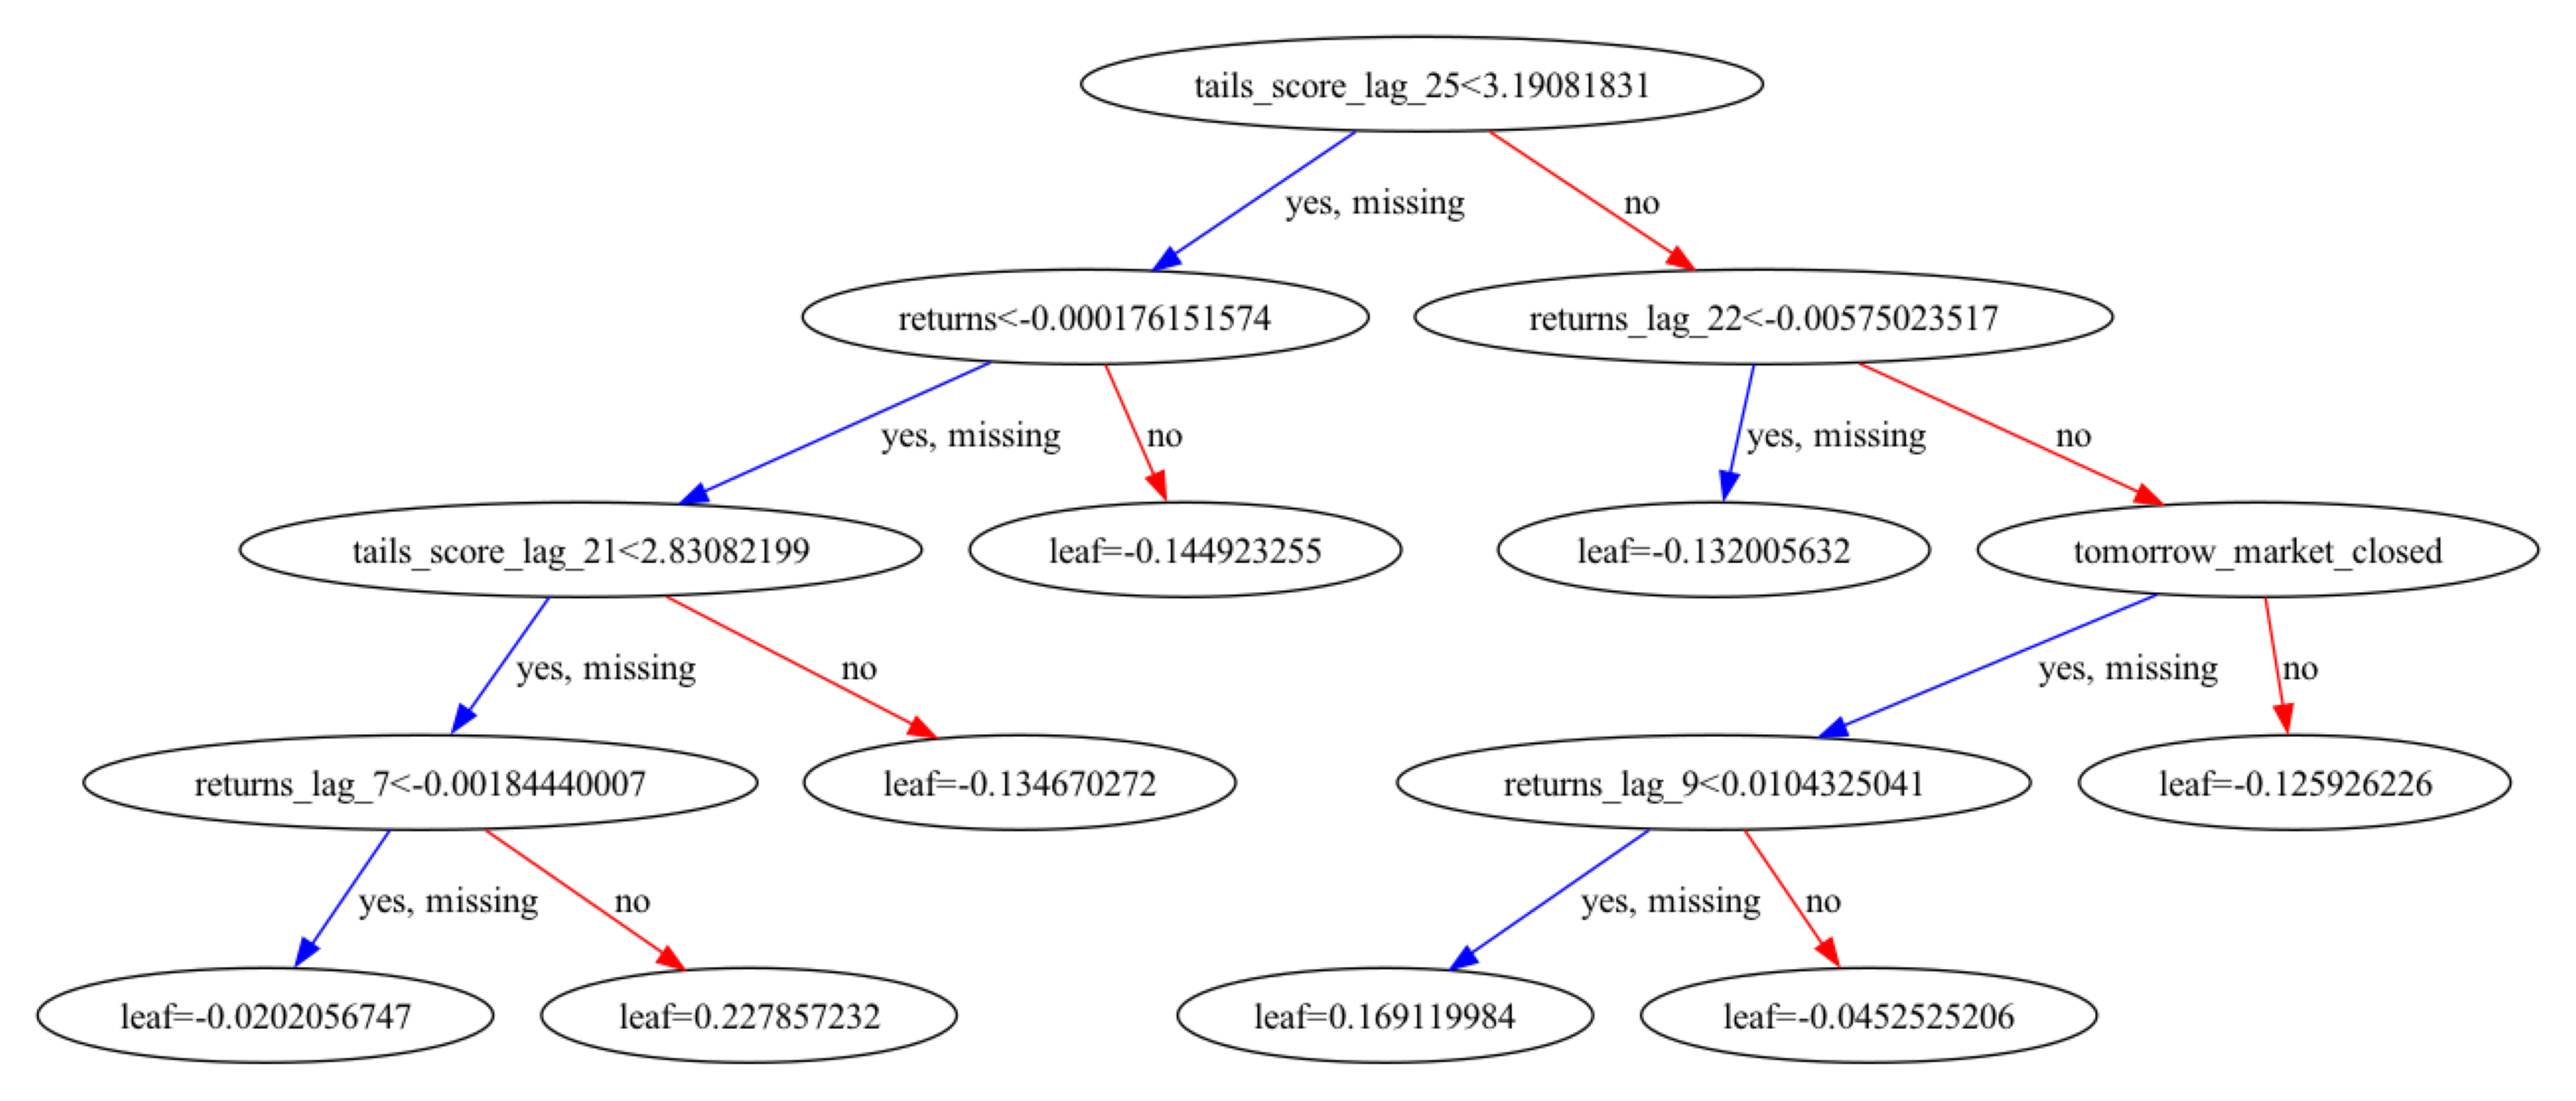

In [31]:
best_model.plot_model_tree()

In [32]:
pred_df["Close"] = test_df.Close
pred_df.to_parquet(f"stocks/predictions/{ticker}.parquet")

In [33]:
def backtest_strategy_with_cash(pred_df, strategy, initial_cash = 0, stocks_to_trade = 1):
    cash = initial_cash
    history = []

    for date, row in pred_df.iterrows():
        stock_price = row.Close

        if row[strategy] == "buy":
            cash -= stocks_to_trade*stock_price
            traded_stocks = +stocks_to_trade
        elif row[strategy] == "sell":
            cash += stocks_to_trade*stock_price
            traded_stocks = -stocks_to_trade
        else:
            traded_stocks = 0
            cash = 0
        history.append({"date" :date , "cash" : cash, "order" : row[strategy], "traded_stocks" : traded_stocks, "stock_price" : stock_price})

    strategy_df = pd.DataFrame(history).set_index("date")
    strategy_df = pd.concat([strategy_df,strategy_df[["cash","traded_stocks"]].cumsum().add_prefix("cum_")], axis = 1)
    strategy_df[f"{strategy}_capital"] = strategy_df.stock_price*strategy_df.cum_traded_stocks + strategy_df.cum_cash
    return strategy_df

In [34]:
def one_day_strategy(pred_df, strategy, stocks_to_trade = 1):
    "This strategy consists in buying today to sell tomorrow / sell today to buy tomorrow and get the difference" 
    earnings = 0
    order_yesterday = None
    stock_price_yesterday = 0
    history = []

    for date, row in pred_df.iterrows():
        stock_price_today = row.Close
        order_today = row[strategy]

        if order_yesterday == "buy":
            earnings += (stock_price_today - stock_price_yesterday) * stocks_to_trade
            
        elif order_yesterday == "sell":
            earnings += (stock_price_yesterday - stock_price_today) * stocks_to_trade

        else:
            earnings = 0
        stock_price_yesterday = stock_price_today
        order_yesterday = order_today
        history.append({"date" :date , "earnings" : earnings,
                        "order_yesterday" : order_yesterday, "order_today" : order_today,
                        "stock_price_yesterday" : stock_price_yesterday,
                        "stock_price_today" : stock_price_today,
                        })

    strategy_df = pd.DataFrame(history).set_index("date")
    strategy_df = pd.concat([strategy_df,strategy_df[["earnings"]].cumsum().add_prefix("cum_")], axis = 1)
    strategy_df = strategy_df.rename(columns = {"cum_earnings" : f"{strategy.replace('_pred', '')}_earnings"})
    return strategy_df

In [35]:
strategies = []
for strategy in pred_df.columns[:-1]:
    results_df = one_day_strategy(pred_df, strategy)
    strategies.append(results_df.iloc[:,-1])
    
strategies_df = pd.concat(strategies, axis = 1)


In [36]:
strategies_df = strategies_df.drop(columns = strategies_df.filter(regex = "target*", axis = 1))

In [37]:
strategies_order = strategies_df.tail(1).iloc[0].sort_values(ascending = False)
palette = sns.color_palette("winter", n_colors = len(strategies_order))

<Axes: xlabel='date', ylabel='Close'>

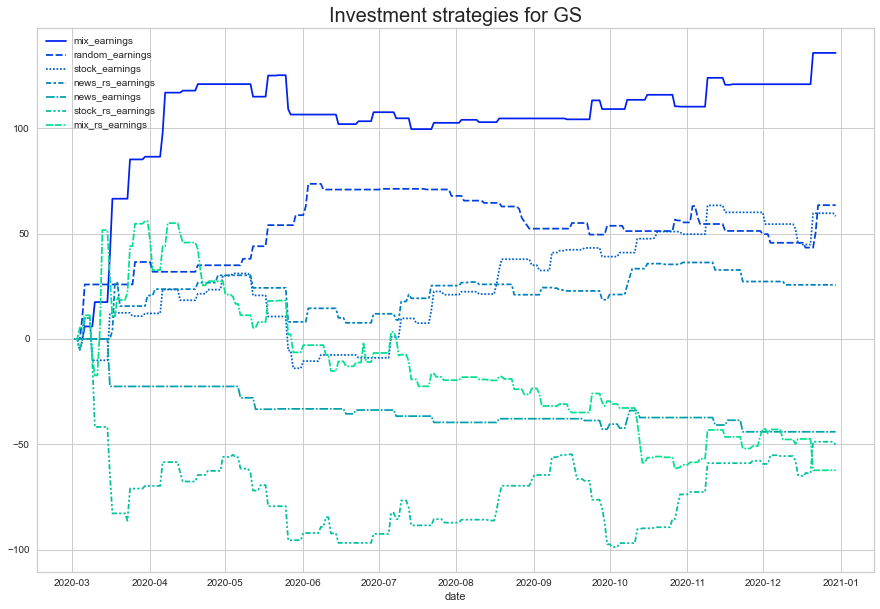

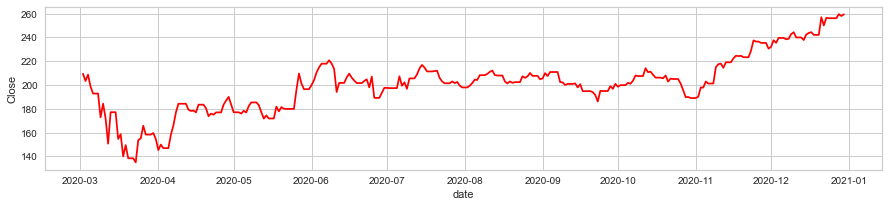

In [38]:
fig, ax = plt.subplots(figsize = (15,10))
sns.lineplot(strategies_df[strategies_order.index], palette = palette)
ax.set_title(f"Investment strategies for {ticker}", fontdict={"size" : 20})
fig, ax = plt.subplots(figsize = (15,3))
sns.lineplot(test_df.Close, color = "red")